In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
warnings.filterwarnings('ignore')

In [66]:
df = pd.read_csv('train.txt', sep=';', header=None, names=['text', 'emotion'])
df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [67]:
df.isnull().sum()

,0
text,0
emotion,0


In [68]:
unique_emotions = df['emotion'].unique()
print("Unique emotions in the dataset:", unique_emotions)

Unique emotions in the dataset: ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


In [69]:
emotion_numbers = {}
i = 0
for emo in unique_emotions:
  emotion_numbers[emo] = i
  i +=1

df['emotion'] = df['emotion'].map(emotion_numbers)

In [70]:
df.head()

,text,emotion
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,1
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,1


# Text Cleaning & Preprocessing




In [71]:
df['text'] = df['text'].apply(lambda x: x.lower())

In [72]:
import string

def remove_punc(txt):
  return txt.translate(str.maketrans('','',string.punctuation))
df['text'] = df['text'].apply(remove_punc)

In [73]:
def remove_numbers(txt):
    new = ""
    for i in txt:
        if not i.isdigit():
            new = new + i
    return new

df['text'] = df['text'].apply(remove_numbers)


In [74]:
def remove_emojis(txt):
    new = ""
    for i in txt:
        if i.isascii():
            new += i
    return new

df['text'] = df['text'].apply(remove_emojis)

In [75]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [76]:
stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor', 'never'}


In [77]:
def remove(txt):
  words = word_tokenize(txt)
  cleaned = []
  for i in words:
    if not i in stop_words:
      cleaned.append(i)

  return ' '.join(cleaned)

df['text'] = df['text'].apply(remove)
df.head()

,text,emotion
0,didnt feel humiliated,0
1,go feeling hopeless damned hopeful around some...,0
2,im grabbing minute post feel greedy wrong,1
3,ever feeling nostalgic fireplace know still pr...,2
4,feeling grouchy,1


# Train test Split

In [78]:
x = df['text']
y = df['emotion']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Modelling

`Multi NB + Bag of Words Vectorizer`

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
bow_vectorizer = CountVectorizer()
x_train_bow = bow_vectorizer.fit_transform(x_train)
x_test_bow = bow_vectorizer.transform(x_test)

In [80]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nb = MultinomialNB()
nb.fit(x_train_bow, y_train)

pred_bow = nb.predict(x_test_bow)
print(accuracy_score(y_test, pred_bow))

0.7659375


`Multi NB + TF-IDF Vectorizer`

In [81]:
Tfidf = TfidfVectorizer(ngram_range=(1,2))
x_train_tfidf = Tfidf.fit_transform(x_train)
x_test_tfidf = Tfidf.transform(x_test)

In [82]:
nb2 = MultinomialNB()
nb2.fit(x_train_tfidf, y_train)
pred_tfidf = nb2.predict(x_test_tfidf)
print(accuracy_score(y_test, pred_tfidf))

0.63875


`Logistic Regression + TF-IDF Vectorizer`

In [83]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(x_train_tfidf, y_train)
pred_tfidf_logistic = logistic_model.predict(x_test_tfidf)
print(accuracy_score(y_test, pred_tfidf_logistic))

0.8425


`Linear SVM + TF-IDF Vectorizer`

In [84]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
x_train_res, y_train_res = ros.fit_resample(x_train_tfidf, y_train)

0.900625
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       946
           1       0.89      0.89      0.89       427
           2       0.82      0.82      0.82       296
           3       0.79      0.81      0.80       113
           4       0.87      0.84      0.85       397
           5       0.92      0.93      0.92      1021

    accuracy                           0.90      3200
   macro avg       0.87      0.87      0.87      3200
weighted avg       0.90      0.90      0.90      3200



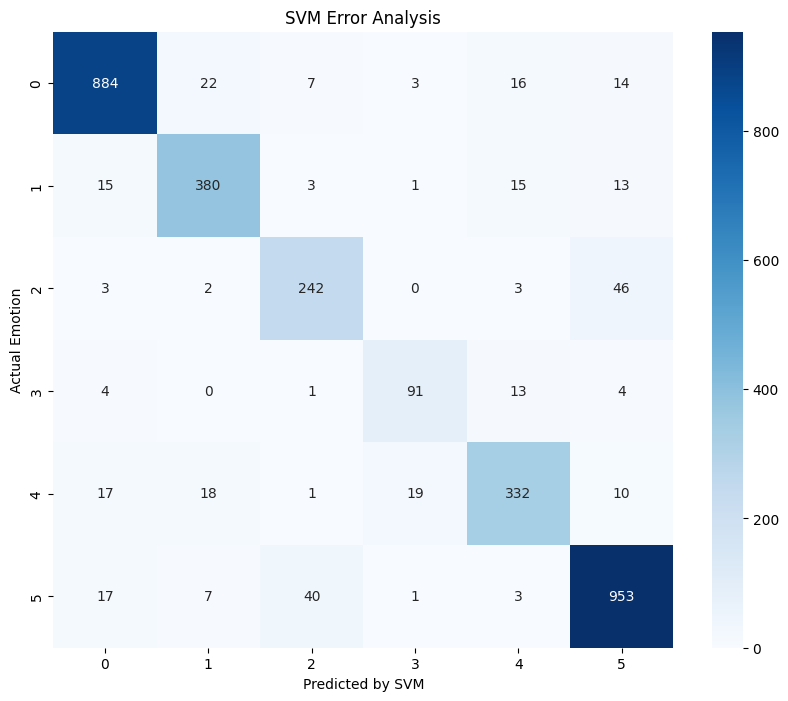

In [85]:
from sklearn.svm import LinearSVC
model = LinearSVC(C=5.0,class_weight='balanced', random_state=42)
model.fit(x_train_res, y_train_res)
pred_tfidf_svm = model.predict(x_test_tfidf)
print(accuracy_score(y_test, pred_tfidf_svm))


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC

# 1. RE-TRAIN SVM (Just to be 100% sure 'model' is SVM, not BERT)
# We use the 'x_train_res' and 'y_train_res' you created in your snippet
svm_model = LinearSVC(C=5.0, class_weight='balanced', random_state=42, dual='auto')
svm_model.fit(x_train_res, y_train_res)

# 2. Predict (Now it's safe to use the sparse matrix)
y_pred_svm = svm_model.predict(x_test_tfidf)

# 3. Get the correct labels dynamically
# (This ensures the plot works whether your labels are 0-5 or 'joy'-'sadness')
unique_labels = svm_model.classes_

# 4. Print Report
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# 5. Plot Heatmap
cm = confusion_matrix(y_test, y_pred_svm, labels=unique_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted by SVM')
plt.ylabel('Actual Emotion')
plt.title('SVM Error Analysis')
plt.show()

`Deep Learning (BERT)`

In [86]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
from sklearn.metrics import accuracy_score

# 1. Prepare Data (BERT needs a dataframe with 'text' and 'labels')
# We use your original x_train, x_test data (before vectorizing!)
train_df = pd.DataFrame({"text": x_train, "labels": y_train})
eval_df = pd.DataFrame({"text": x_test, "labels": y_test})

# 2. Configure the Model
model_args = ClassificationArgs()
model_args.num_train_epochs = 2          # BERT learns fast. 2-3 epochs is enough.
model_args.learning_rate = 1e-4          # Standard learning rate
model_args.overwrite_output_dir = True   # Overwrite previous runs
model_args.train_batch_size = 32         # Lower this if you run out of memory

# 3. Load BERT (DistilBERT is faster and 99% as good)
model = ClassificationModel(
    "distilbert",
    "distilbert-base-uncased",
    num_labels=6,
    args=model_args,
    use_cuda=True  # Set to False if you don't have a GPU
)

# 4. Train
model.train_model(train_df)

# 5. Evaluate
# 'result' gives raw numbers, 'wrong_predictions' helps you debug
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=accuracy_score)

print(f"BERT Accuracy: {result['acc']}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 1 of 2:   0%|          | 0/400 [00:00<?, ?it/s]

Running Epoch 2 of 2:   0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/32 [00:00<?, ?it/s]

BERT Accuracy: 0.9334375


  0%|          | 0/6 [00:00<?, ?it/s]

Predicting:   0%|          | 0/32 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       946
           1       0.90      0.96      0.93       427
           2       0.83      0.92      0.87       296
           3       0.89      0.71      0.79       113
           4       0.89      0.90      0.90       397
           5       0.96      0.94      0.95      1021

    accuracy                           0.93      3200
   macro avg       0.91      0.90      0.90      3200
weighted avg       0.94      0.93      0.93      3200



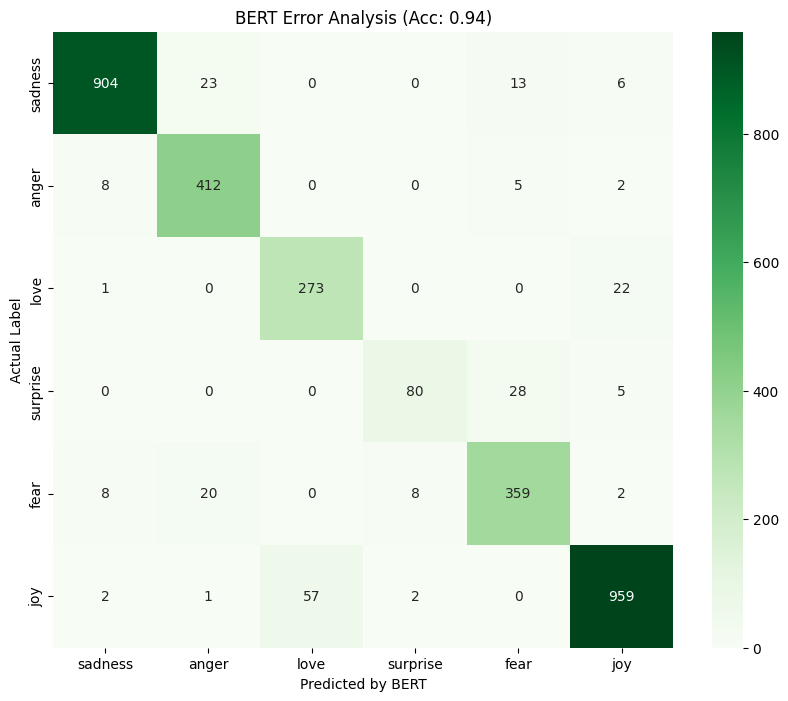

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Get predictions using the BERT model
# Note: BERT takes a list of raw text strings, not TF-IDF vectors
# This might take a minute as it runs the test set
predictions, raw_outputs = model.predict(x_test.tolist())

# 2. Print the Report
print(classification_report(y_test, predictions))

# 3. Plot the Heatmap
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))

# Ensure these labels match the order of your classes (0-5)
labels = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted by BERT')
plt.ylabel('Actual Label')
plt.title('BERT Error Analysis (Acc: 0.94)')
plt.show()